# Manifold Learning and Graph Kernels
### Requirements 
Read [this article](http://www.dsi.unive.it/~atorsell/AI/graph/Unfolding.pdf) presenting a way to improve the disciminative power of graph kernels.
Choose one [graph kernel](http://www.dsi.unive.it/~atorsell/AI/graph/kernels.pdf) among

* Shortest-path Kernel
* Graphlet Kernel
* Random Walk Kernel
* Weisfeiler-Lehman Kernel


Choose one manifold learning technique among

* Isomap
* Diffusion Maps
* Laplacian Eigenmaps
* Local Linear Embedding


Compare the performance of an SVM trained on the given kernel, with or without the manifold learning step, on the following datasets:

* [PPI](http://www.dsi.unive.it/~atorsell/AI/graph/PPI.mat): this is a Protein-Protein Interaction dataset. Here proteins (nodes) are connected by an edge in the graph if they have a physical or functional association.
* [Shock](http://www.dsi.unive.it/~atorsell/AI/graph/Shock.mat): representing 2D shapes. Each graph is a skeletal-based representation of the differential structure of the boundary of a 2D shape.

**Note**: the datasets are contained in Matlab files. The variable `G` contains a vector of cells, one per graph. 
The entry `am` of each cell is the adjacency matrix of the graph.
The variable `labels`, contains the class-labels of each graph.	


### Imports

In [1]:
import scipy.io as sio
import numpy as np
import sys
import threading
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
from collections import Counter
from sklearn import svm, manifold, preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.svm import SVC

### Read the datasets
* Load the datasets
* Take the `G` and `labels` fields
* `G` consists in a list containing a list of arrays. Remove the external list. Afterwards take only the `am` field
* `labels` consists in many one-element lists. Create a single list removing one depth level


In [10]:
BASE_URI = '/home/lorenzo/Dropbox/manifold-learning-and-graph-kernels/dataset/'
SHOCK_URI = 'SHOCK.mat'
PPI_URI = 'PPI.mat'
# `G` and `labels`
SHOCK = sio.loadmat(BASE_URI + SHOCK_URI)
SHOCK_G = SHOCK['G'][0] # read and get rid of external list
# print(SHOCK_G.dtype.names) 
# [('am', 'O'), ('nl', 'O'), ('al', 'O')]
SHOCK_G_adj = SHOCK_G['am'] # take only the adjacency matrix
SHOCK_labels = SHOCK['labels'].ravel() # read and get rid of useless 1-element lists
assert len(SHOCK_G_adj) == len(SHOCK_labels)
del SHOCK
PPI = sio.loadmat(BASE_URI + PPI_URI)
PPI_G = PPI['G'][0]
PPI_G_adj = PPI_G['am']
PPI_labels = PPI['labels'].ravel()
assert len(PPI_G_adj) == len(PPI_labels)
del PPI

# Weisfeiler-Lehman
### Algorithm

1. Multiset label determination
    * assign a multiset label $M_i(v)$ to each node $v \in G$ which consists of the multiset $\{l_{i-1}(u)$ | u is a neighbor of v$\}$
        * done in `determine_labels`
        * as per the paper, since our graphs are unlabelled, we use the node-degrees as starting labels for the node


2. Sorting each multiset
    * Sort elements in $M_i(v)$ in ascending order and concatenate them into a string $s_i(v)$
        * sorted and merged in `get_labels` 
    * Add $l_{i−1}(v)$ as a prefix to $s_i(v)$
        * done in `extend_labels`. Returns the string formatted as requested


3. Label compression
    * Map each string $s_i(v)$ to a compressed label using a hash function $f : \Sigma^∗ \rightarrow \Sigma$ such that $f(s_i(v)) = f(s_i (w))$ if and only if $s_i(v) = s_i(w)$
        * done in `compress_label` and `relabel`
    * As the first "hash", I use the highest degree of a node in all graphs, plus one (hence I'm sure that one is a hash instead of an original label


4. Relabeling
    * Set $l_i(v) = f(s_i(v))$ for all nodes in $G$ 
        * done in `relabel`


After having done all of the above, the similarity matrix for the N graphs is computed.
The `run()` method returns the similarity matrix containing the normalized values for all the graphs.

In [60]:
class WeisfeilerLehman:
    '''
    Get a graph's starting labels (node degrees).
    graph --> actual graph
    '''
    def get_graph_starting_labels(self, graph):
        return np.dot(graph, np.ones((len(graph), 1)))
    
    
    '''
    Get the starting labels for all the graphs (node degrees)
    {index of the graph in the graphs list : array representing starting label}
    '''
    def get_all_starting_labels(self):
        starting_labels = {g : self.get_graph_starting_labels(self.graphs[g]) 
                                                              for g in range(self.n)}
        return starting_labels
    
    
    '''
    Get the highest degree of a node throughout all graphs
    '''
    def get_max_global_degree(self):
        return max([max(v) for _, v in self.get_all_starting_labels().items()])
    
    
    '''
    Get the neighbors of a node
    g --> index of the graph
    node --> index of the node
    neighbors --> list with indices of the neighbors
    '''
    def get_neighbors(self, g, node):
        graph = self.graphs[g]
        neighbors = [j for j in range(len(graph)) if graph[node][j] == 1]
        return neighbors
    
    
    '''
    Get updated labels for a node as per (1)
    g --> index of the graph
    node --> index of the node in the graph
    
    Take the labels of the neighbors of a node, sort them, merge them into an unique string
    '''
    def get_labels(self, g, node):
        new_label = sorted([self.labels[g][i] for i in self.get_neighbors(g, node)])
        new_label = ''.join(str(int(i)) for i in new_label)
        return new_label
    
    
    '''
    Compute the new multiset of labels of each node in a graph.
    Return a dictionary in which the key is the index of the node and the value is the string returned from the 
            `get_labels` function
    g --> index of the graph in the graphs array
    '''
    def determine_labels(self, g):
        new_labels = {k : self.get_labels(g, k) for k in range(len(self.graphs[g]))}
        return new_labels
    
    
    '''
    Return the string obtained from the sorted multiset 
    g --> index of the graph in the array
    '''
    def extend_labels(self, g, new_labels):
        for k in new_labels: # new_labels is a dict
            new_labels[k] = self.labels[g][k] + new_labels[k]
        return new_labels    
    
    
    '''
    Compress a label if it has not been compressed already
    {long_label : compressed_index}
    '''
    def compress_label(self, label):
        if label not in self.compressed_labels:
            self.compressed_labels[label] = str(self.compressed_index)
            self.compressed_index += 1
        return self.compressed_labels[label]
    
    
    '''
    Relabel all the nodes in a graph
    '''
    def relabel(self, g, new_labels):
        # print(f'OLD: {self.labels}')
        assert len(new_labels) == len(self.labels[g])
        for i in range(len(new_labels)):
            self.labels[g][i] = self.compress_label(new_labels[i])
        # print(f'NEW: {self.labels}')
        
    
    
    '''
    Count the original node labels: return a list with the number of occurrences per each label
    g --> index of the graph
    [0, 1, 2, 3, 1] --> 0 nodes with label 0, 1 node with label 1, ..., 1 node with label 4
    '''
    def count_original_node_labels(self, g):
        phi = []
        ol = list(map(int, self.original_labels[g]))
        c = Counter(ol)
        for k in range(max(ol)+1):
            if k in c:
                phi.append(c[k])
            else:
                phi.append(0)
        return phi
    
    
    '''
    Count node labels at current iteration: return a list with the number of occurrences per each label
    g --> index of the graph
    '''
    def count_node_labels_at_current_iteration(self, g):
        phi = []
        l = list(map(int, [i for _, i in self.compressed_labels.items()]))
        c = Counter(l)
        for k in range(max(l)+1):
            if k in c:
                phi.append(c[k])
            else:
                phi.append(0)
        return phi
    
    
    '''
    Prepare feature vectors for the dot product. Make the shorter ones as long as the long ones,
    concatenate, and so on.
    g1, g2 --> indices of two graphs
    '''
    def prepare_feature_vectors(self, g1, g2):
        l1 = self.count_labels[g1]
        l2 = self.count_labels[g2]
        # print(f'l1:{l1}\n')
        # print(f'l2:{l2}\n')
        tot1 = []
        tot2 = []
        for i in range(self.h+1):
            if len(l1[i]) > len(l2[i]):
                a1, a2 = np.array(l1[i]), np.zeros(len(l1[i]))
                for j in range(len(l2[i])):
                    a2[j] = l2[i][j]
                # print(f'a1:{a1}')
                # print(f'a2:{a2}')
            else:
                a1, a2 = np.zeros(len(l2[i])), np.array(l2[i])
                for j in range(len(l1[i])):
                    a1[j] = l1[i][j]
                # print(f'a1:{a1}')
                # print(f'a2:{a2}')
            tot1 = np.concatenate((tot1, a1), axis=0)
            tot2 = np.concatenate((tot2, a2), axis=0)
            # print(f'tot1:{tot1}')
            # print(f'tot2:{tot2}')
        return tot1, tot2
    
    
    '''
    Normalize similarity matrix: sum per rows must be = 1
    '''
    def normalize_sim_matrix(self):
        self.pairwise_sim_matrix = preprocessing.normalize(self.pairwise_sim_matrix)
        return self.pairwise_sim_matrix
    
    '''
    Pairwise similarities between all the graphs (unnormalized)
    '''
    def pairwise_similarities(self):
        for i in range(self.n):
            for j in range(i, self.n):
                g1, g2 = self.prepare_feature_vectors(i, j)
                # print(f'g1\n{g1}\n')
                # print(f'g2\n{g2}\n\n\n')
                dotp = np.dot(g1, g2)
                # print(dotp)
                self.pairwise_sim_matrix[i][j] = dotp
                self.pairwise_sim_matrix[j][i] = dotp
        # print(self.pairwise_sim_matrix)
        self.normalize_sim_matrix()
        return self.pairwise_sim_matrix
    
    '''
    Run the whole algorithm: steps 1, 2, 3, 4
    '''
    def run(self):
        for i in range(self.h):
            for g in range(self.n): # g is the index of the graph in the array of graphs
                print(f'old labels of {g} at iteration {i} : {self.labels[g]}')
                new_labels = self.determine_labels(g)
                new_labels = self.extend_labels(g, new_labels)
                self.relabel(g, new_labels)
                self.count_labels[g][i+1] = self.count_node_labels_at_current_iteration(g)
                print(f'new labels of {g} at iteration {i} : {self.labels[g]}')
            # print('\n\n')
            # print(self.labels)
        return self.pairwise_similarities()

    '''
    Initialize everything and run the algorithm h times
    '''
    def __init__(self, graphs, h):
        self.n = len(graphs)
        self.graphs = graphs
        self.h = h
        self.labels = self.get_all_starting_labels()
        self.labels = { 
                        index : [str(int(degree)) for degree in self.labels[index].ravel()] 
                                                  for index in self.labels 
                      }
        # print(self.labels)
        self.original_labels = deepcopy(self.labels)
        # self.compressed_index = 0
        self.compressed_index = int(self.get_max_global_degree()[0]) + 1
        self.compressed_labels = {}
        self.count_labels = {} # {iterazione1 : {grafo1 : conteggio1, grafo2 : conteggio2, ...}, ...}
        for i in range(self.n):
            self.count_labels[i] = {}
            self.count_labels[i][0] = self.count_original_node_labels(i)            
        del self.original_labels
        # print(self.count_labels)
        self.pairwise_sim_matrix = np.zeros((self.n, self.n))
        # print(self.labels)
        
    


### Compute similarity matrices for PPI and SHOCK

In [62]:
# x = [PPI_G_adj[i] for i in range(20, 50)]
# print(x)

x = [PPI_G_adj[44], PPI_G_adj[45], PPI_G_adj[46]]
wl_PPI = WeisfeilerLehman(x, 2)

# wl_PPI = WeisfeilerLehman(PPI_G_adj,2)
# print(wl_PPI.run())


# wl_PPI = WeisfeilerLehman(PPI_G_adj,2)
wl_PPI.run()

# wl_SHOCK = WeisfeilerLehman(SHOCK_G_adj, 3)
# t1 = threading.Thread(name="PPI", target=wl_PPI.run)
# t2 = threading.Thread(name="SHOCK", target=wl_SHOCK.run)
# threads = [t1, t2]
# for t in threads:
#     t.start()
# for t in threads:
#     t.join()

# SHOCK_sm = wl_SHOCK.pairwise_sim_matrix

PPI_sm = wl_PPI.pairwise_sim_matrix
print(PPI_sm)
# print([PPI_G_adj[i] for i in range(40,50)])

old labels of 0 at iteration 0 : ['3', '3', '3', '5', '2', '2']
new labels of 0 at iteration 0 : ['13', '13', '13', '14', '15', '15']
old labels of 1 at iteration 0 : ['3', '3', '3', '5', '2', '2']
new labels of 1 at iteration 0 : ['13', '13', '13', '14', '15', '15']
old labels of 2 at iteration 0 : ['1', '2', '5', '4', '5', '5', '5', '12', '2', '9', '5', '3', '3', '1', '1', '7', '1', '8', '1', '4', '4', '1', '6', '2', '1', '4', '2', '4', '2', '4', '8', '4', '2', '3', '3', '1', '3', '4', '1', '3', '1', '1', '3', '4', '1', '1', '1', '2']
new labels of 2 at iteration 0 : ['16', '17', '18', '19', '18', '18', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '28', '32', '33', '34', '35', '36', '28', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '27', '47', '48', '27', '49', '27', '28', '50', '19', '16', '51', '51', '52']
old labels of 0 at iteration 1 : ['13', '13', '13', '14', '15', '15']
new labels of 0 at iteration 1 : ['53', '53', '53', '54', '55', '

### Plot the similarity matrices

[[0.00000000e+00 0.00000000e+00 5.15864429e-02 3.88837049e-02
  5.17022054e-02 5.33979990e-02 2.78301211e-01 3.51710646e-01
  3.30270081e-01 5.77252236e-02 5.77252236e-02 6.36135430e-02
  3.49873635e-01 3.25137047e-01 1.06993303e-01 3.66835551e-01
  1.63525592e-01 1.53420569e-01 1.44028342e-01 1.82684982e-01
  2.65005776e-01 2.21213755e-01 4.50767453e-01 3.07780632e-01
  4.98166068e-01 4.98166068e-01 3.82586229e-01 4.57076320e-01
  4.91967638e-01 3.45105456e-01]
 [0.00000000e+00 0.00000000e+00 5.15864429e-02 3.88837049e-02
  5.17022054e-02 5.33979990e-02 2.78301211e-01 3.51710646e-01
  3.30270081e-01 5.77252236e-02 5.77252236e-02 6.36135430e-02
  3.49873635e-01 3.25137047e-01 1.06993303e-01 3.66835551e-01
  1.63525592e-01 1.53420569e-01 1.44028342e-01 1.82684982e-01
  2.65005776e-01 2.21213755e-01 4.50767453e-01 3.07780632e-01
  4.98166068e-01 4.98166068e-01 3.82586229e-01 4.57076320e-01
  4.91967638e-01 3.45105456e-01]
 [5.15864429e-02 5.15864429e-02 0.00000000e+00 5.94320329e-02
  3.

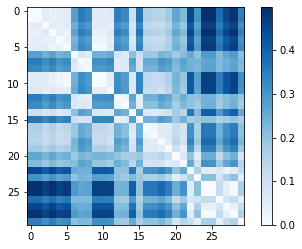

In [31]:
PPI_pd = pairwise_distances(PPI_sm, metric='euclidean')
print(PPI_pd)
# SHOCK_pd = pairwise_distances(SHOCK_sm, metric='euclidean')
plt.imshow(PPI_pd, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();
plt.show()

### SVM

In [32]:
strat_k_fold = StratifiedKFold(n_splits = 10, shuffle = True) 
clf = svm.SVC(kernel="linear", C = 1.0)
scores_ln = cross_val_score(clf, PPI_pd, PPI_labels[20:50], cv = strat_k_fold)
print(str(np.min(scores_ln)) +" - "+str(np.mean(scores_ln))+ " - " + str(np.max(scores_ln)) + " - "+ str(np.std(scores_ln)))

0.6666666666666666 - 0.9333333333333332 - 1.0 - 0.13333333333333336
